In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

Load Data

In [4]:
df = pd.read_csv("subscription_renewal_prediction.csv")

In [5]:
print(df.shape)
display(df.head())
df.info()
df.describe()

(1000, 5)


,user_id,usage_days,last_login,monthly_fee,renewed
0,1,6,0,9.99,0
1,2,19,4,19.99,1
2,3,28,13,9.99,1
3,4,14,8,14.99,1
4,5,10,13,14.99,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      1000 non-null   int64  
 1   usage_days   1000 non-null   int64  
 2   last_login   1000 non-null   int64  
 3   monthly_fee  1000 non-null   float64
 4   renewed      1000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 39.2 KB


,user_id,usage_days,last_login,monthly_fee,renewed
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,14.940000,6.874000,14.820000,0.598000
std,288.819436,9.033493,4.373014,4.029558,0.490547
min,1.000000,0.000000,0.000000,9.990000,0.000000
25%,250.750000,7.000000,3.000000,9.990000,0.000000
50%,500.500000,15.000000,7.000000,14.990000,1.000000
75%,750.250000,23.000000,11.000000,19.990000,1.000000
max,1000.000000,29.000000,14.000000,19.990000,1.000000


Exploratory Data Analaysis (EDA)

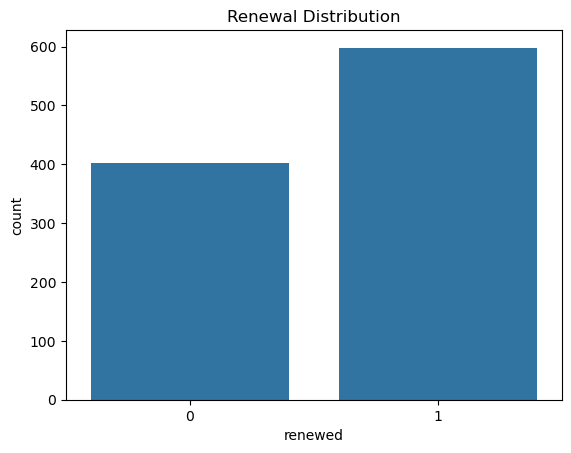

In [6]:
sns.countplot(x='renewed', data=df)
plt.title('Renewal Distribution')
plt.show()

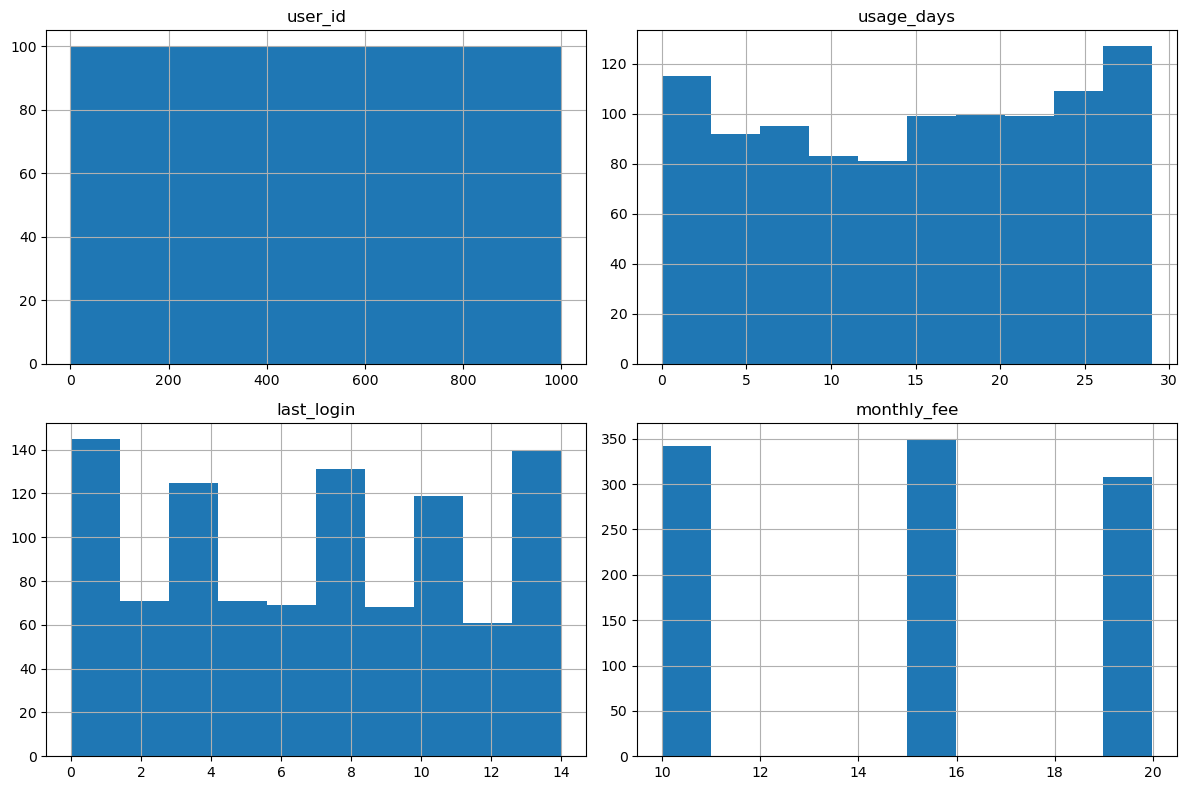

In [7]:
numeric_cols = df.select_dtypes(include='number').columns.drop('renewed')
df[numeric_cols].hist(figsize=(12,8))
plt.tight_layout()
plt.show()

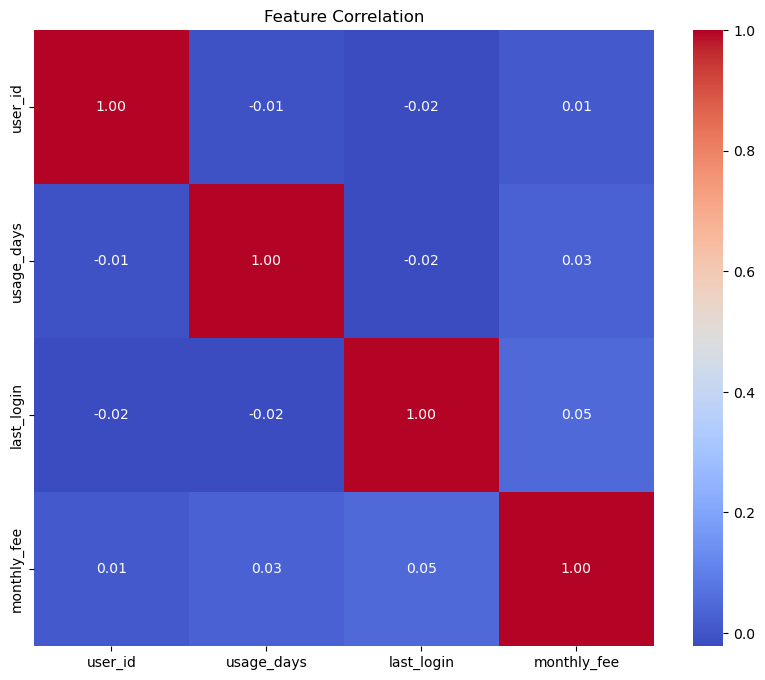

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

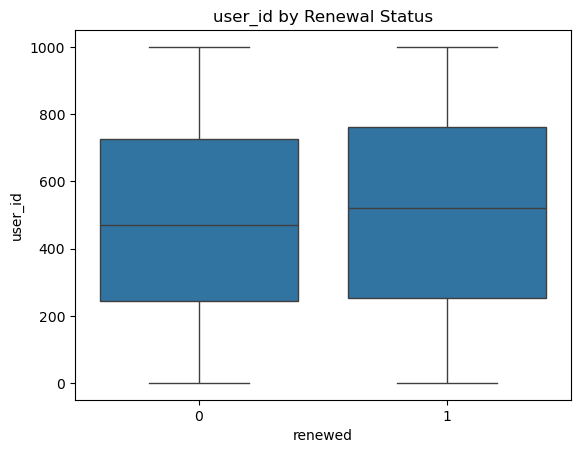

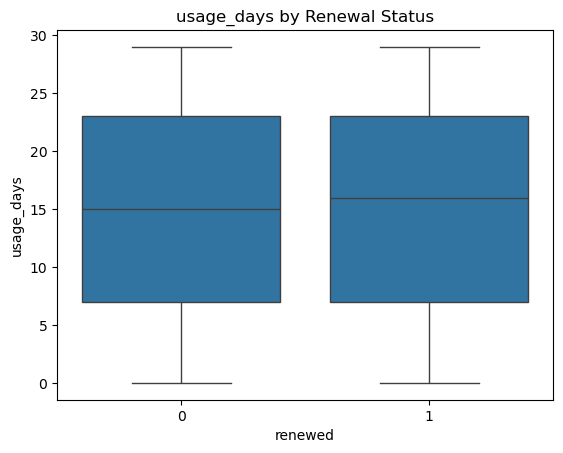

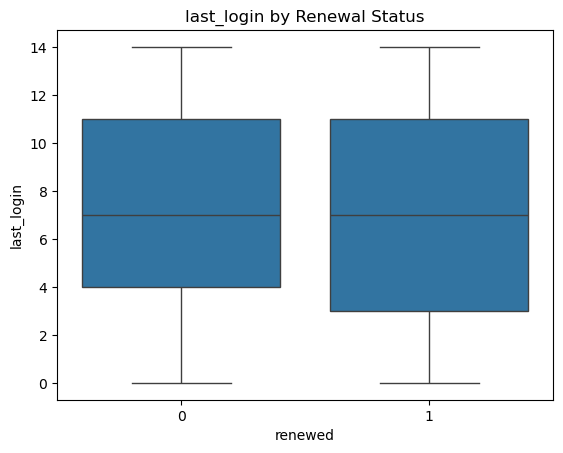

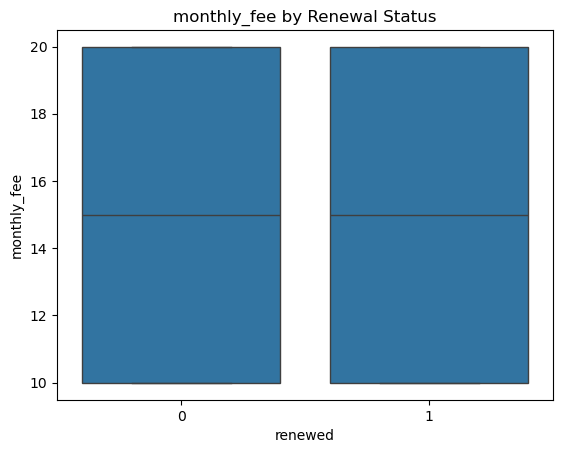

In [9]:
for col in numeric_cols[:4]:
    plt.figure()
    sns.boxplot(x='renewed', y=col, data=df)
    plt.title(f'{col} by Renewal Status')
    plt.show()

In [10]:
# 4a. Check missing values
print("Missing values per column:")
print(df.isna().sum())

# 4b. Drop any rows missing the target, then impute remaining missing with median
df = df.dropna(subset=['renewed'])
df = df.fillna(df.median())
print("\nAfter imputation, first 5 rows:")
display(df.head())

# 4c. Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("\nCategorical columns to encode:", cat_cols)

df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("\nAfter encoding, first 5 rows:")
display(df_enc.head())

# 4d. Split features/target and show shapes
X = df_enc.drop('renewed', axis=1)
y = df_enc['renewed']
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# 4e. Scale numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nScaled feature matrix preview (first 5 rows):")
print(X_scaled[:5])

Missing values per column:
user_id        0
usage_days     0
last_login     0
monthly_fee    0
renewed        0
dtype: int64

After imputation, first 5 rows:


,user_id,usage_days,last_login,monthly_fee,renewed
0,1,6,0,9.99,0
1,2,19,4,19.99,1
2,3,28,13,9.99,1
3,4,14,8,14.99,1
4,5,10,13,14.99,0



Categorical columns to encode: []

After encoding, first 5 rows:


,user_id,usage_days,last_login,monthly_fee,renewed
0,1,6,0,9.99,0
1,2,19,4,19.99,1
2,3,28,13,9.99,1
3,4,14,8,14.99,1
4,5,10,13,14.99,0



Feature matrix shape: (1000, 4)
Target vector shape: (1000,)

Scaled feature matrix preview (first 5 rows):
[[-1.73031962 -0.99014555 -1.57270028 -1.19924241]
 [-1.72685552  0.44966342 -0.65754155  1.28366113]
 [-1.72339142  1.44645424  1.4015656  -1.19924241]
 [-1.71992731 -0.10410926  0.25761718  0.04220936]
 [-1.71646321 -0.54712741  1.4015656   0.04220936]]


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=RSEED
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print("\ny_train class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\ny_test class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

X_train shape: (800, 4)
X_test shape:  (200, 4)

y_train class distribution:
renewed
1    0.5975
0    0.4025
Name: proportion, dtype: float64

y_test class distribution:
renewed
1    0.6
0    0.4
Name: proportion, dtype: float64


In [12]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RSEED),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=RSEED),
    # 'Naive Bayes': GaussianNB()
}

baseline_results = {}

for name, model in models.items():
    # cross-val accuracy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    # fit & predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # metrics
    baseline_results[name] = {
        'CV Accuracy': f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}",
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

# Display results
results_df = pd.DataFrame({m: {k: v for k, v in res.items() if k!='Confusion Matrix'}
                           for m, res in baseline_results.items()}).T
display(results_df)

,CV Accuracy,Test Accuracy,Precision,Recall,F1-Score
Decision Tree,0.480 ± 0.035,0.535,0.608,0.633333,0.620408
KNN,0.510 ± 0.018,0.575,0.622378,0.741667,0.676806
Random Forest,0.489 ± 0.035,0.515,0.583942,0.666667,0.622568


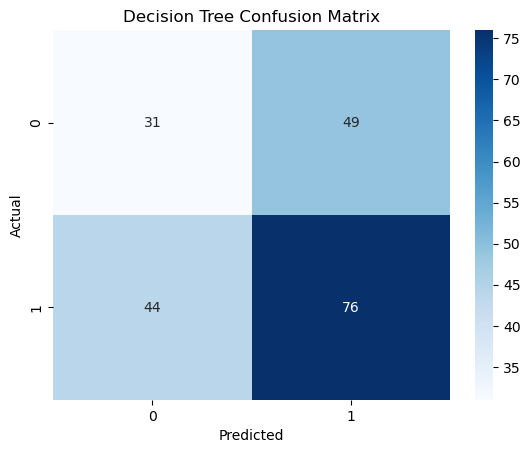

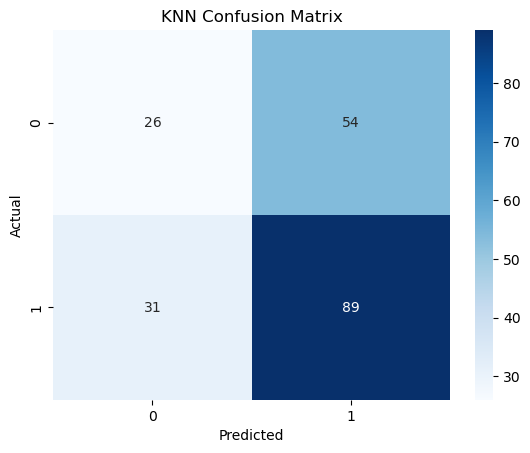

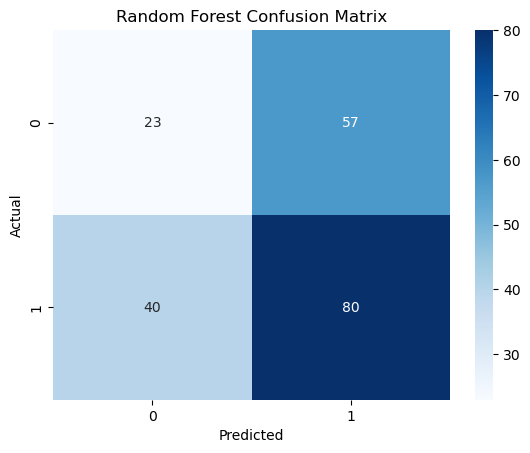

In [13]:
for name, res in baseline_results.items():
    cm = res['Confusion Matrix']
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [14]:
pca = PCA(n_components=0.95, random_state=RSEED)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print("Original feature count:", X_train.shape[1])
print("PCA components retained:", pca.n_components_)

Original feature count: 4
PCA components retained: 4


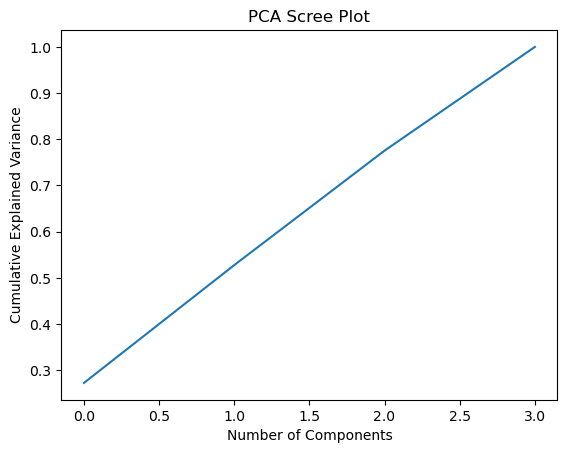

In [15]:
# Scree plot
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.show()

In [16]:
pca_results = {}

for name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
    cv_scores = cross_val_score(model, X_train_pca, y_train, cv=cv, scoring='accuracy')
    
    model.fit(X_train_pca, y_train)
    y_pred_pca = model.predict(X_test_pca)
    
    pca_results[name] = {
        'CV Accuracy': f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}",
        'Test Accuracy': accuracy_score(y_test, y_pred_pca),
        'Precision': precision_score(y_test, y_pred_pca),
        'Recall': recall_score(y_test, y_pred_pca),
        'F1-Score': f1_score(y_test, y_pred_pca),
        'Confusion Matrix': confusion_matrix(y_test, y_pred_pca)
        }

# Display PCA results
pca_df = pd.DataFrame({m: {k: v for k, v in res.items() if k!='Confusion Matrix'}
                       for m, res in pca_results.items()}).T
display(pca_df)

,CV Accuracy,Test Accuracy,Precision,Recall,F1-Score
Decision Tree,0.549 ± 0.020,0.505,0.586777,0.591667,0.589212
KNN,0.510 ± 0.018,0.575,0.622378,0.741667,0.676806
Random Forest,0.511 ± 0.025,0.605,0.641379,0.775,0.701887


In [17]:
compare = pd.concat(
    [results_df.add_suffix(' (orig)'), pca_df.add_suffix(' (PCA)')], axis=1
)
display(compare)

,CV Accuracy (orig),Test Accuracy (orig),Precision (orig),Recall (orig),F1-Score (orig),CV Accuracy (PCA),Test Accuracy (PCA),Precision (PCA),Recall (PCA),F1-Score (PCA)
Decision Tree,0.480 ± 0.035,0.535,0.608,0.633333,0.620408,0.549 ± 0.020,0.505,0.586777,0.591667,0.589212
KNN,0.510 ± 0.018,0.575,0.622378,0.741667,0.676806,0.510 ± 0.018,0.575,0.622378,0.741667,0.676806
Random Forest,0.489 ± 0.035,0.515,0.583942,0.666667,0.622568,0.511 ± 0.025,0.605,0.641379,0.775,0.701887


In [18]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.6000
Decision Tree Accuracy: 0.5550
Random Forest Accuracy: 0.5300
KNN Accuracy: 0.5500


In [19]:
print("\nCross-Validation Accuracy:")

cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    cv_scores[name] = scores.mean()
    print(f"{name} CV Accuracy: {scores.mean():.4f}")



Cross-Validation Accuracy:
Logistic Regression CV Accuracy: 0.5890
Decision Tree CV Accuracy: 0.5000
Random Forest CV Accuracy: 0.5180
KNN CV Accuracy: 0.4540


In [20]:
best_model_name = max(cv_scores, key=cv_scores.get)
print("\nBest Model:", best_model_name)
print("Best CV Accuracy:", cv_scores[best_model_name])



Best Model: Logistic Regression
Best CV Accuracy: 0.5890000000000001


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)



Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy: 0.5762500000000002


In [22]:
best_model = grid.best_estimator_

y_final_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_final_pred)

print("\nFinal Test Accuracy:", final_accuracy)



Final Test Accuracy: 0.58


In [23]:
import joblib

# save trained model
joblib.dump(model, "model.pkl")

print("Model saved successfully")


Model saved successfully
